<a href="https://colab.research.google.com/github/AryanXTH/AI-and-ML/blob/main/AI_CourseWork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Recurrent Neural Network and It’s Variant.

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Required Libraries

In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# import contractions
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')           # if using word_tokenize
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# About the Dataset

The dataset contains two columns headline and category where there are 5 different types of news category - Sports, Tech, Money, Culture & Arts, and Education.

An model is to be built which can classify the type of news according to the headline provided.

In [7]:
df = pd.read_csv("/content/news_category.csv") # loading the dataset into a dataframe

## Exploratory Data Analysis

### Printing random samples from dataframe

In [8]:
df.sample(10)

,headline,category
9744,Wife Cooks Money That Husband Hid In Oven,MONEY
4069,"After Canceling Panel On Harassment, SXSW Now ...",TECH
3424,Next Year's Super Bowl Mascot Will Make You Ha...,SPORTS
7097,My Personal Experience on How to Save Tens of ...,MONEY
8858,Powerball Jackpot At $214 Million; Next Drawin...,MONEY
5514,How a Student from the Non-College Track Becam...,EDUCATION
2825,How Andre Iguodala Fixed His Sleep Game,SPORTS
1711,Russell Westbrook’s Reaction To An Angry Fan F...,SPORTS
1854,The Moment This Dad Broke Down At His Son's ML...,SPORTS
373,McKayla Maroney Says Larry Nassar Abused Her H...,SPORTS


In [9]:
# Print all column names
for column in df.columns.tolist():
    print(column)

headline
category


In [10]:
df.size

22050

In [11]:
df.isnull().sum()

,0
headline,0
category,0


In [12]:
# Check for duplicates
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 78


## Initial Vizualization of data

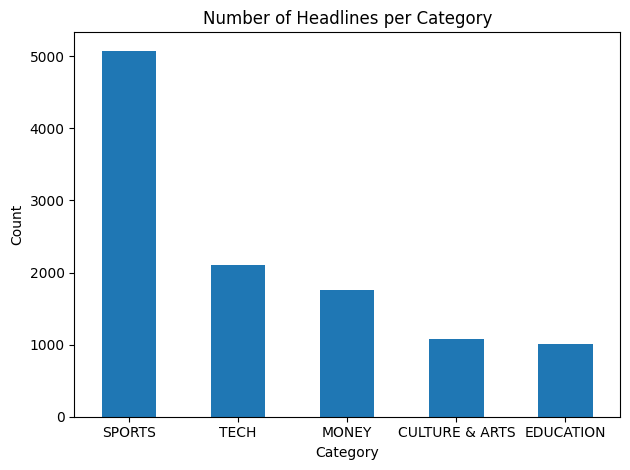

In [13]:
category_counts = df['category'].value_counts()

category_counts.plot(kind="bar")
plt.title('Number of Headlines per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

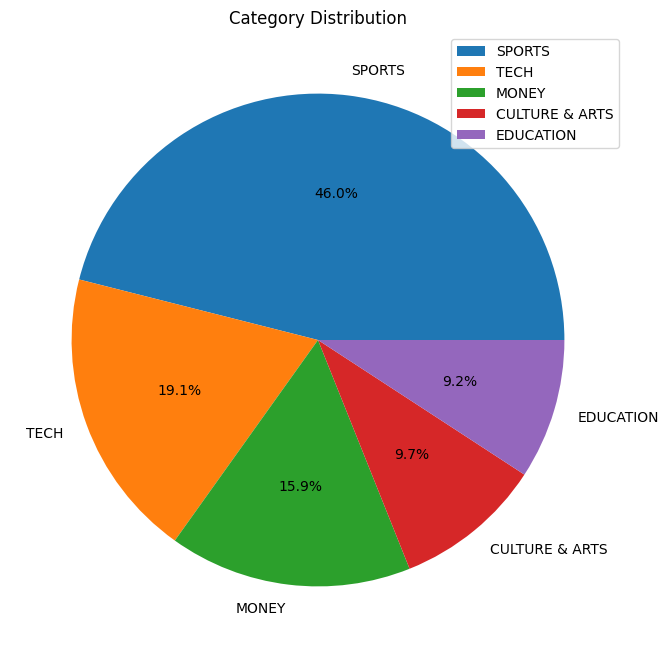

In [14]:
df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(15,8))
plt.title('Category Distribution')
plt.ylabel('')
plt.legend()
plt.show()

## Data preprocessing

### Convert all texts to lowercase

In [15]:
def lower_case(text):
  """
  This function converts all the text in input text to lower order.
  Input Args:
  text : input text.
  Returns:
  lower_text : text converted to small/lower order.
  """
  lower_text = text.lower()
  return lower_text

### Remove the URLs

In [16]:
def remove_urls(text):
  """
  This function will try to remove URL present in out dataset and replace it with space using regex library.
  Input Args:
  text: string of text that may contain URLs.
  Output Args:
  text: URLs replaces with text
  """
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)


### Remove Unwanted Emojis or blockers from text

In [17]:
def remove_emoji(text):
  """
  This function will replace the emoji in string with whitespace.
  Input Args:
  text: string of text that may contain URLs.
  Output Args:
  emoji_removed_text: URLs replaces with text.
  """
  emoji_removed_text = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_removed_text.sub(r' ', text)

### Remove unwanted characters

In [18]:
def removeunwanted_characters(document):
  """
  This function will remove all the unwanted characters from the input dataset.
  Input Args:
  document: A text data to be cleaned.
  Return:
  document: A cleaned document.
  """
  # remove user mentions
  document = re.sub("@[A-Za-z0-9_]+"," ", document)
  # remove hashtags
  document = re.sub("#[A-Za-z0-9_]+","", document)
  # remove punctuation
  document = re.sub("[^0-9A-Za-z ]", "" , document)
  #remove emojis
  document = remove_emoji(document)
  # remove double spaces
  document = document.replace('  ',"")
  return document.strip()

### Remove Punctuations

In [19]:
def remove_punct(text):
  """
  This function removes the punctutations present in our text data.
  Input Args:
  text: text data.
  Returns:
  text: cleaned text.
  """
  tokenizer = RegexpTokenizer(r"\w+")
  lst=tokenizer.tokenize(' '.join(text))
  return lst

### Remove Stopwords

In [20]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text_tokens):
  """
  This function removes all the stopwords present in out text tokens.
  Input Args:
  text_tokens: tokenize input of our datasets.
  Returns:
  result_tokens: list of token without stopword.
  """

  result_tokens = []
  for token in text_tokens:
    if token not in stop_words:
       result_tokens.append(token)
  return result_tokens

### Handle Contractions

Convert words like don't --> do not

In [21]:
def handle_contractions(text):
    """
    This function removes all the contractions
    Input Args:
    text: text as input
    Returns:
    result_tokens: contractions handled texts
    """
    return contractions.fix(text)

### Lemmatization

In [22]:
def lemmatization(token_text):
  """
  This function performs the lemmatization operations as explained above.
  Input Args:
  token_text: list of tokens.
  Returns:
  lemmatized_tokens: list of lemmatized tokens.
  """
  wordnet = WordNetLemmatizer()
  lemmatized_tokens = [wordnet.lemmatize(token, pos = 'v') for token in token_text]

  return lemmatized_tokens

In [23]:
def text_cleaning_pipeline(dataset):
   """
   This function compiles all the text cleaning functions using lemmatization, and prepare it for
   model training.

   Input Args:
   dataset: all dataset

   Returns:
   tokens: tokenized and cleaned dataset
   """
   # Convert the input to small/lower order.
   data = lower_case(dataset)
   # Remove URLs
   data = remove_urls(data)
   # Remove emojis
   data = remove_emoji(data)
   # Remove all other unwanted characters.
   data = removeunwanted_characters(data)
   # Create tokens.
   tokens = data.split()
   # Remove stopwords:
   tokens = remove_punct(tokens)
   tokens = remove_stopwords(tokens)
   tokens = lemmatization(tokens)

   return " ".join(tokens)

In [24]:
df["cleaned_headline"]  = df["headline"].apply(text_cleaning_pipeline)
df["cleaned_category"]  = df["category"].apply(text_cleaning_pipeline)

# Drop old columns from the DataFrame
df.drop(["headline", "category"], axis=1, inplace=True)

In [25]:
df.sample(10)

,cleaned_headline,cleaned_category
1817,colin kaepernick death threats kill would prov...,sport
9820,brave new world tomorrows tablets,tech
2182,michael jordan finally break silence police br...,sport
7855,vince low pay homage famous dyslexics realisti...,culturearts
6197,extremists ban uk link qatar world cup bid,sport
9587,program thats get veterans home,money
10139,ask readers dont people talk money,money
105,ny yankees make rachel balkovec 1st woman mana...,sport
4245,area man swallow whole live breathe tarp,sport
1836,exusa gymnastics doctor accuse sexual abuse tw...,sport


## Visualize Cleaned Data

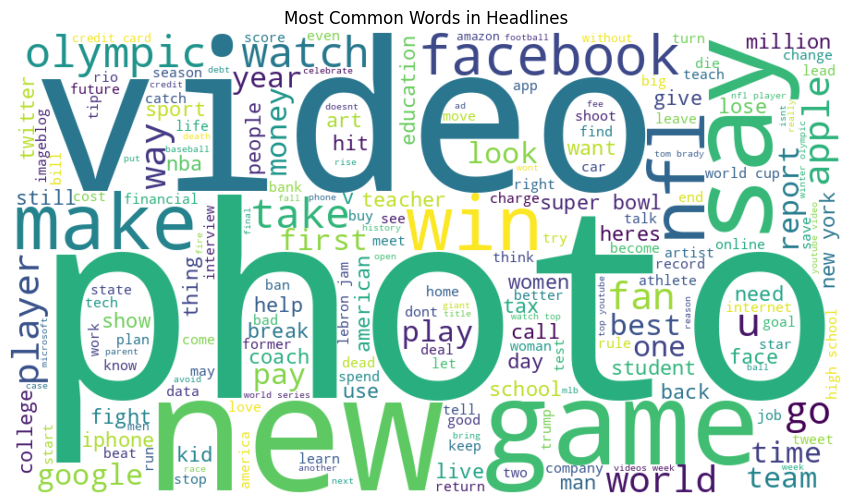

In [26]:
text = ' '.join(df['cleaned_headline'])

# Generate WordCloud
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Headlines")
plt.show()

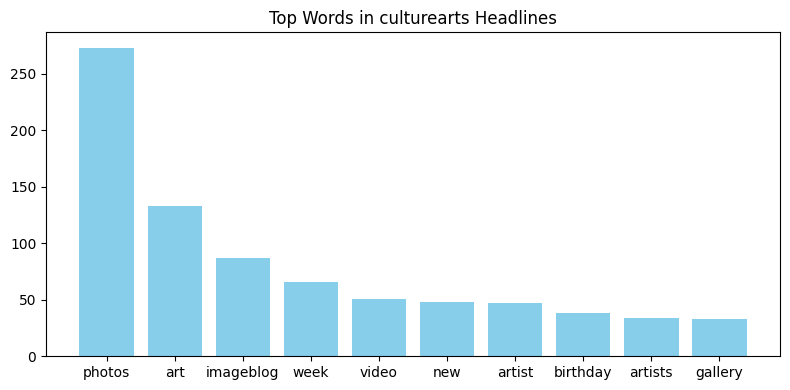

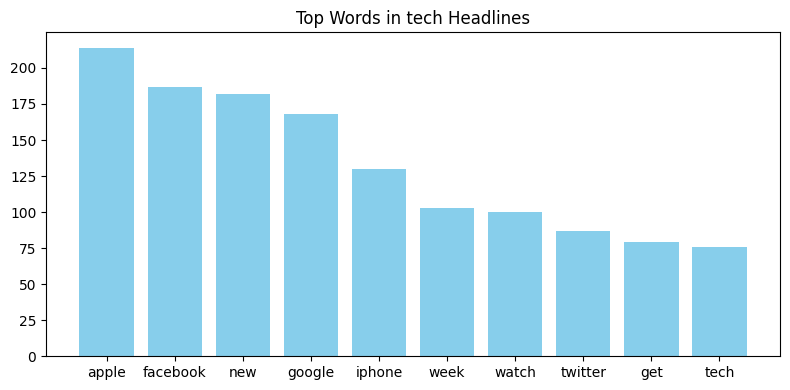

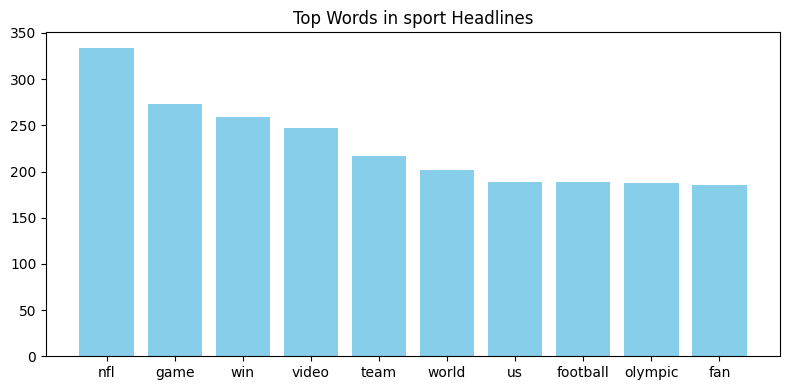

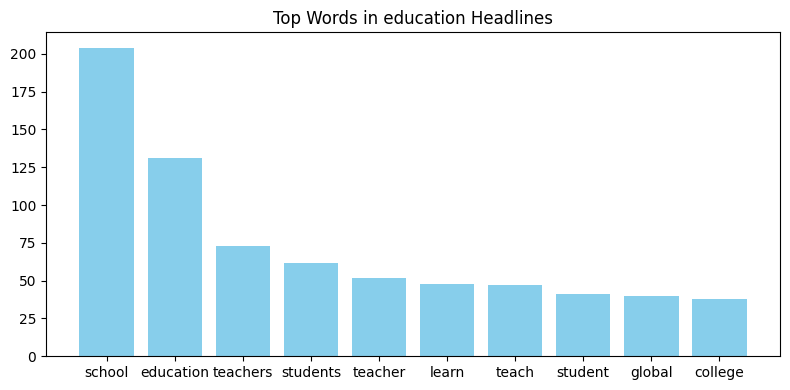

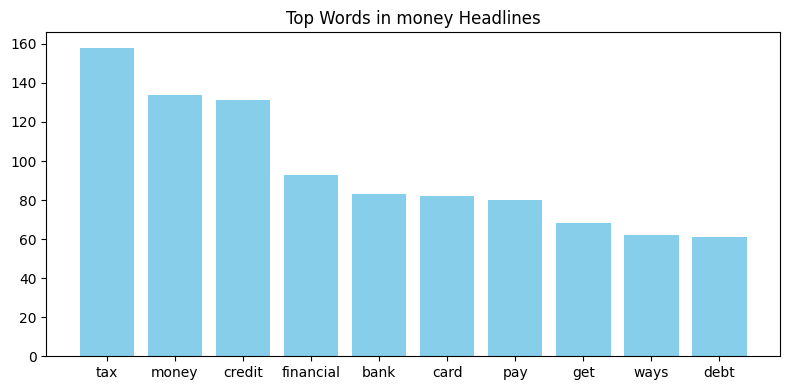

In [27]:
from collections import Counter

categories = df['cleaned_category'].unique()

for category in categories:
    tokens = [
        word
        for token_list in df[df['cleaned_category'] == category]['cleaned_headline']
        for word in (token_list if isinstance(token_list, list) else token_list.split())
    ]

    word_freq = Counter(tokens).most_common(10)

    words, counts = zip(*word_freq)
    plt.figure(figsize=(8, 4))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=0)
    plt.title(f"Top Words in {category} Headlines")
    plt.tight_layout()
    plt.show()

## Tokenization and Padding

### Splitting dataset into 80% training and 20% testing

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_headline'], df['cleaned_category'], test_size=0.2, random_state=42)

### Tokenizing text into sequences of integers

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # Fit tokenizer on training data

texts = df['cleaned_headline']

# Pad sequences
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post')

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index


In [30]:
# Assigned Labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"{label} → {idx}")

Label Mapping:
culturearts → 0
education → 1
money → 2
sport → 3
tech → 4


In [48]:
# import pickle

# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# with open('label_encoder.pkl', 'wb') as f:
#    pickle.dump(le, f)

In [31]:
print(X_train_seq[0])

[148, 662, 273, 2117, 148, 503]


### Applying padding to all sequences for them to have the same length

In [32]:
# Calculate the percentile length (e.g., 80th percentile)
max_len = int(np.percentile([len(seq) for seq in X_train_seq], 80))

# Pad sequences to make sure they're all the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)

In [33]:
print("Example padded sequence:", X_train_pad[0])

Example padded sequence: [ 148  662  273 2117  148  503    0    0    0]


# Model Building and Training

## Simple RNN model

should use - rnn model.add(Embedding(input dim= , output dim= , input length= ))

In [34]:
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        SimpleRNN(64),
        Dense(6, activation='softmax')
    ])
    return model

In [35]:
rnn_model = build_rnn_model()
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.build(input_shape=(None, max_len))
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 128)         │     1,566,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,579,334 (6.02 MB)

 Trainable params: 1,579,334 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
print(type(X_train_pad), X_train_pad.dtype)
print(type(y_train), y_train.dtype)

<class 'numpy.ndarray'> int32
<class 'numpy.ndarray'> int64


In [37]:
# Train
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
rnn_model_history = rnn_model.fit(X_train_pad, y_train, validation_split=0.2, epochs=10, callbacks=[early_stop])

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5330 - loss: 1.2299 - val_accuracy: 0.8027 - val_loss: 0.6073
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9280 - loss: 0.2508 - val_accuracy: 0.8124 - val_loss: 0.5955
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9880 - loss: 0.0567 - val_accuracy: 0.8118 - val_loss: 0.7168
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9959 - loss: 0.0178 - val_accuracy: 0.8016 - val_loss: 0.7982
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9985 - loss: 0.0080 - val_accuracy: 0.7948 - val_loss: 0.8818


## LSTM Model

In [38]:
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        LSTM(64),
        Dense(6, activation='softmax')
    ])
    return model

In [39]:
lstm_model = build_lstm_model()
lstm_model.build(input_shape=(None, max_len))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 9, 128)         │     1,566,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,616,390 (6.17 MB)

 Trainable params: 1,616,390 (6.17 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train
lstm_model_history = rnn_model.fit(X_train_pad, y_train, validation_split=0.2, epochs=10, callbacks=[early_stop])

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9848 - loss: 0.0630 - val_accuracy: 0.8084 - val_loss: 0.7161
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9914 - loss: 0.0309 - val_accuracy: 0.8050 - val_loss: 0.7801
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9975 - loss: 0.0104 - val_accuracy: 0.8010 - val_loss: 0.8527
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9996 - loss: 0.0037 - val_accuracy: 0.7988 - val_loss: 0.9323


## Word2Vec Model

In [67]:
!pip uninstall -y tsfresh
!pip install gensim==4.3.3 numpy==1.26.4 scipy==1.13.1 --force-reinstall


Found existing installation: tsfresh 0.21.0
Uninstalling tsfresh-0.21.0:
  Successfully uninstalled tsfresh-0.21.0
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully unins

In [1]:
import gensim.downloader as api

embedding_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [41]:
embedding_dim = 300 # Match with downloaded GloVe model dimension
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in embedding_model:
        embedding_vector = embedding_model[word]
        embedding_matrix[i] = embedding_vector
    else:
        # Words not found in embedding index will be all-zeros
        pass

word2vec_model = Sequential()
word2vec_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=padded_sequences.shape[1],
    trainable=False
))
word2vec_model.add(LSTM(64, return_sequences=False))
word2vec_model.add(Dense(6, activation='softmax'))  # For binary classification
word2vec_model.build(input_shape=(None, max_len))
word2vec_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
word2vec_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 9, 300)         │     3,671,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,765,530 (14.36 MB)

 Trainable params: 93,830 (366.52 KB)

 Non-trainable params: 3,671,700 (14.01 MB)

In [42]:
word2vec_history = word2vec_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6301 - loss: 1.0081 - val_accuracy: 0.8263 - val_loss: 0.5156
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8537 - loss: 0.4396 - val_accuracy: 0.8385 - val_loss: 0.4627
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8781 - loss: 0.3651 - val_accuracy: 0.8454 - val_loss: 0.4436
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8844 - loss: 0.3369 - val_accuracy: 0.8508 - val_loss: 0.4407
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8929 - loss: 0.3084 - val_accuracy: 0.8549 - val_loss: 0.4374
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9073 - loss: 0.2737 - val_accuracy: 0.8467 - val_loss: 0.4754
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9156 - loss: 0.2517 - val_accuracy: 0.8549 - val_loss: 0.4707
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9307 - loss: 0.2026 - val_accuracy: 0.

# Model Evaluation

## Appropriate Loss Function

In [43]:
def plot_history(history, title):
    print(f"------------------------------ {title} ------------------------------ \n\n")
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f"{title} Accuracy Plot")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f"{title} Loss Function Plot")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [44]:
def evaluation_plot(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype("int32")

        # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:\n", classification_report(y_test, y_pred_classes))

    print("\n\n\n--------------------------------------------------------------------")

In [45]:
models = [
    {'model': rnn_model, 'history': rnn_model_history, 'title': "RNN Model"},
    {'model': lstm_model, 'history': lstm_model_history, 'title': "LSTM Model"},
    {'model': word2vec_model, 'history': word2vec_history, 'title': "Word2Vec LSTM Model3"}
]

------------------------------ RNN Model ------------------------------ 




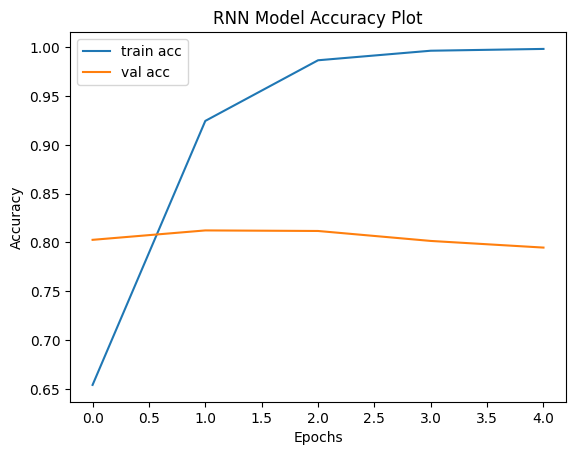

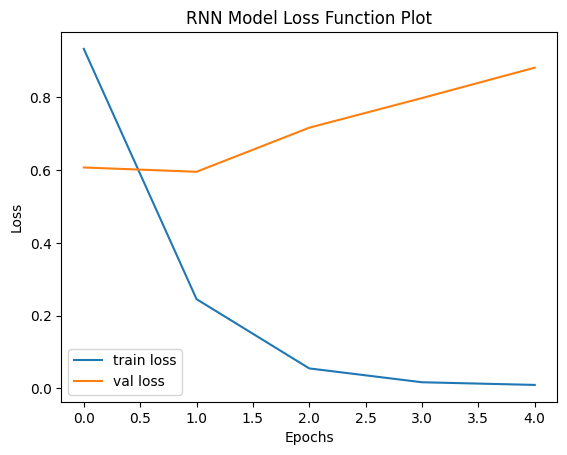

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


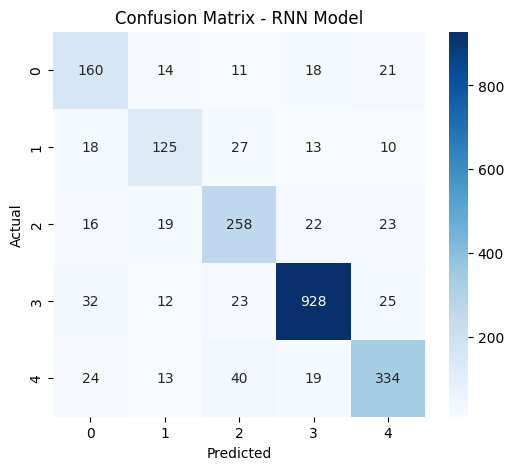

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.71      0.68       224
           1       0.68      0.65      0.66       193
           2       0.72      0.76      0.74       338
           3       0.93      0.91      0.92      1020
           4       0.81      0.78      0.79       430

    accuracy                           0.82      2205
   macro avg       0.76      0.76      0.76      2205
weighted avg       0.82      0.82      0.82      2205




--------------------------------------------------------------------
------------------------------ LSTM Model ------------------------------ 




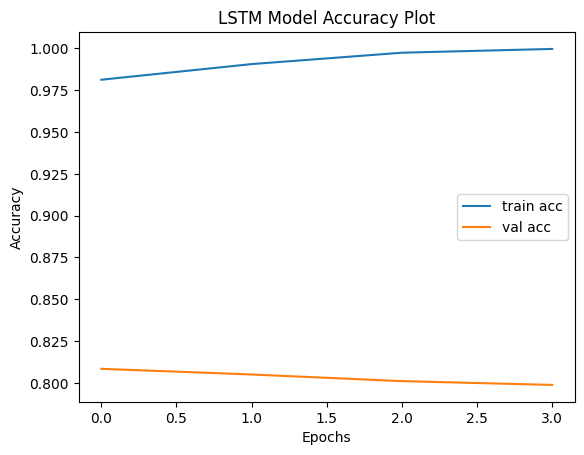

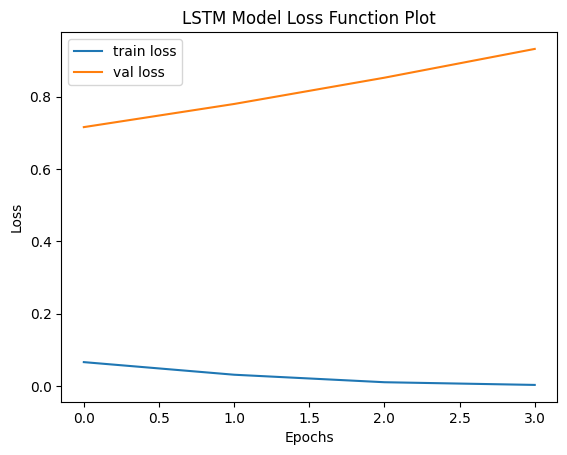

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


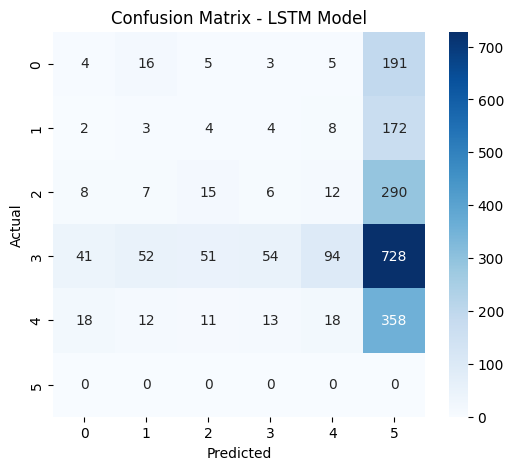

Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.02      0.03       224
           1       0.03      0.02      0.02       193
           2       0.17      0.04      0.07       338
           3       0.68      0.05      0.10      1020
           4       0.13      0.04      0.06       430
           5       0.00      0.00      0.00         0

    accuracy                           0.04      2205
   macro avg       0.18      0.03      0.05      2205
weighted avg       0.37      0.04      0.07      2205




--------------------------------------------------------------------
------------------------------ Word2Vec LSTM Model3 ------------------------------ 




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


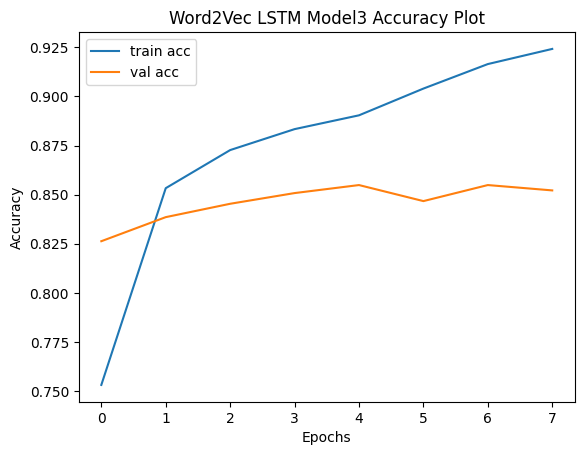

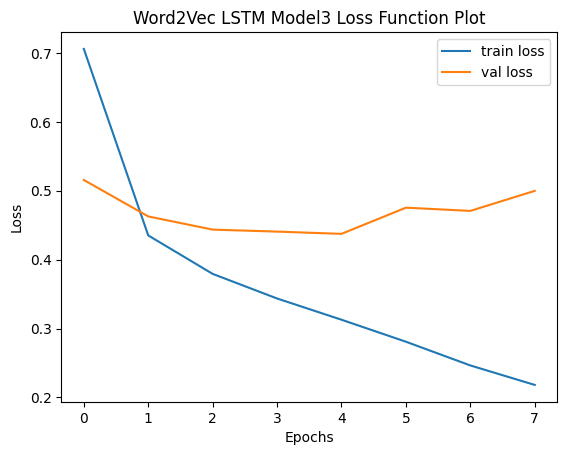

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


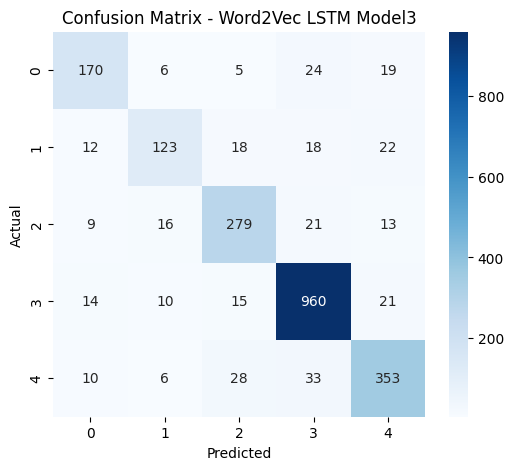

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77       224
           1       0.76      0.64      0.69       193
           2       0.81      0.83      0.82       338
           3       0.91      0.94      0.92      1020
           4       0.82      0.82      0.82       430

    accuracy                           0.85      2205
   macro avg       0.82      0.80      0.81      2205
weighted avg       0.85      0.85      0.85      2205




--------------------------------------------------------------------


In [46]:
for model_info in models:
    plot_history(model_info['history'], model_info['title'])
    evaluation_plot(model_info['model'], X_test_pad, y_test, model_info['title'])

In [47]:
word2vec_model.save("news_category_model.h5")